In [1]:
from ekarus.e2e.single_stage_ao_class import SingleStageAO
# from ekarus.e2e.devices.pyramid_wfs import PyramidWFS

from ekarus.e2e.utils.image_utils import reshape_on_mask#, image_grid
import ekarus.e2e.utils.my_fits_package as myfits
from arte.utils.radial_profile import computeRadialProfile

from numpy.ma import masked_array
import matplotlib.pyplot as plt
import xupy as xp
import os


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
amp = 50e-9

atmo_tn = 'nine_layers_25mOS'

ssao = SingleStageAO(tn='calib_amplitude_8m')
ssao.initialize_turbulence(tn=atmo_tn)

r0s = ssao.atmo_pars['r0']
windSpeeds = ssao.atmo_pars['windSpeed']
r0 = (1/xp.sum(r0s**(-5/3)))**(3/5)
Vwind = xp.mean(windSpeeds)
atmo_prefix = f'r0{r0*1e+2:1.0f}cm_V{Vwind:1.0f}_'

saveprefix = f'rMod{ssao.pyr.modulationAngleInLambdaOverD:1.0f}_'

KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=2)
Rec, IM = ssao.compute_reconstructor(ssao.sc, KL, ssao.pyr.lambdaInM, ampsInM=amp, save_prefix=saveprefix)
ssao.sc.load_reconstructor(IM,m2c)

ang_prefix = ''#'deg45_'
saveprefix += ang_prefix

lambdaRef = ssao.pyr.lambdaInM


Initializing devices ...
Modulating 4 [lambda/D] with 28 modulation steps
Fried parameter is: 5.0 [cm] (seeing = 2.02")


In [3]:
# atmo_phase = ssao.get_phasescreen_at_time(0.6)
# atmo_phase -= xp.mean(atmo_phase[~ssao.cmask])

# phi = atmo_phase[~ssao.cmask]
# modes = xp.linalg.pinv(KL.T) @ phi

# rec_phi = KL.T @ modes
# rec_phase = reshape_on_mask(rec_phi, ssao.cmask)

# delta_phase = atmo_phase - rec_phase

# sh = 1.0

# plt.figure(figsize=(18,4))
# plt.subplot(1,3,1)
# plt.imshow(masked_array(xp.asnumpy(atmo_phase),xp.asnumpy(ssao.cmask)), origin='lower')
# plt.colorbar(shrink=sh)
# plt.title('Atmosphere')
# plt.subplot(1,3,2)
# plt.imshow(masked_array(xp.asnumpy(rec_phase),xp.asnumpy(ssao.cmask)), origin='lower')
# plt.colorbar(shrink=sh)
# plt.title('KL reconstructed')
# plt.subplot(1,3,3)
# plt.imshow(masked_array(xp.asnumpy(delta_phase),xp.asnumpy(ssao.cmask)), origin='lower')
# plt.colorbar(shrink=sh)
# plt.title('Difference')

# print(f'RMS of the reconstructed phase is: {xp.sqrt(xp.sum(rec_phi**2)/len(rec_phi))*1e+9:1.2f} [nm], sum of KL coefficients is: {xp.sum(abs(modes))*1e+9:1.2f} [nm]')

In [4]:
# ssao2m = SingleStageAO(tn='calib_amplitude')
# res_phase, = ssao2m.load_telemetry_data(['residual_phases'], save_prefix='r010cm_V15_')

# plt.figure()
# plt.imshow(res_phase[100],origin='lower')
# plt.colorbar()

# def get_residual(id:int):
#     return xp.asarray(res_phase[id].data[~res_phase[id].mask])

In [5]:
# pupilDiameterInM = 8
# lambdaInM = 750e-9
# oversampling = 4
# lambdaOverD = lambdaInM/pupilDiameterInM

# apex_angle = 100*(2*xp.pi)*lambdaOverD
# wfs = PyramidWFS(apex_angle, oversampling, sensorLambda=lambdaInM)
# wfs.set_modulation_angle(0.0)


In [6]:
def get_mtf(wfs, phase, mask, D, show:bool=False):

    phase_in_rad = reshape_on_mask(phase, mask)*2*xp.pi/wfs.lambdaInM
    input_field = (1-mask) * xp.exp(1j*phase_in_rad,dtype=wfs.cdtype)

    L = max(input_field.shape)
    padded_field = xp.pad(input_field, int((wfs.oversampling-1)/2*L), mode='constant', constant_values=0.0)
    phase_delay = wfs.pyramid_phase_delay(padded_field.shape) / (wfs.lambdaInM/D)

    if wfs._modNsteps > 0:
        intensity = xp.zeros(padded_field.shape,dtype=wfs.dtype)
        tiltX,tiltY = wfs._get_XY_tilt_planes(padded_field.shape)
        alpha_pix = wfs.modulationAngleInLambdaOverD*wfs.oversampling*(2*xp.pi)
        phi_vec = (2*xp.pi)*xp.arange(wfs._modNsteps)/wfs._modNsteps

        for phi in phi_vec:
            tilt = tiltX * xp.cos(phi) + tiltY * xp.sin(phi)
            tilted_input = padded_field * xp.exp(1j*tilt*alpha_pix, dtype=wfs.cdtype)
            field_on_focal_plane = xp.fft.fftshift(xp.fft.fft2(tilted_input))
            ef_focal_plane_delayed = field_on_focal_plane * xp.exp(1j*phase_delay, dtype=wfs.cdtype)
            intensity += xp.abs(ef_focal_plane_delayed)**2 / wfs._modNsteps
    else:
        field_on_focal_plane = xp.fft.fftshift(xp.fft.fft2(padded_field))
        ef_focal_plane_delayed = field_on_focal_plane * xp.exp(1j*phase_delay, dtype=wfs.cdtype)
        intensity = xp.abs(ef_focal_plane_delayed)**2

    otf = xp.fft.fftshift(xp.fft.fft2(intensity))
    mtf = abs(otf)

    if show:
        plt.figure()
        plt.imshow(xp.asnumpy(xp.log(mtf)),origin='lower',cmap='twilight')
        # plt.imshow(masked_array(xp.asnumpy(xp.log(mtf)),xp.asnumpy(~padded_mask)),origin='lower',cmap='twilight')
        plt.colorbar()

    return mtf

In [7]:
# x,y = ssao.dm.act_coords

# IFs = ssao.dm.IFF.copy()
# Rec = xp.linalg.pinv(IFs)

# mask = ssao.dm.mask.copy()
# X,Y = image_grid(mask.shape,recenter=True)
# X = X[~mask]
# Y = Y[~mask]

# N = 64
# M = int(xp.sum(1-mask))
# s = xp.pi / (xp.max(X) - xp.min(X))
# idx = xp.arange(N, dtype=int)[:, None] 
# fourier_mat = xp.cos(idx * s * X[None, :])
# fourier_inv = xp.linalg.pinv(fourier_mat)


In [8]:
# mode10 = fourier_mat[10,:]
# mode20 = fourier_mat[20,:]
# amp = 50e-9
# shape = reshape_on_mask(mode20*amp,mask)
# oversampling = 6
# input_field =(1-mask) * xp.exp(1j*shape*2*xp.pi/lambdaInM,dtype=xp.complex128)
# padded_field = xp.pad(input_field, pad_width=int(max(input_field.shape)*(oversampling-1))//2, mode='constant', constant_values=0.0+0.0*1j)
# focal_field = xp.fft.fftshift(xp.fft.fft2(padded_field))
# psf = xp.abs(focal_field)**2

# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.imshow(xp.asnumpy(shape),origin='lower',cmap='RdGy')
# plt.colorbar()
# plt.subplot(1,2,2)
# plt.imshow(xp.asnumpy(xp.log(psf)),origin='lower',cmap='twilight')
# plt.colorbar()
# plt.xlim([50*oversampling,90*oversampling])
# plt.ylim([50*oversampling,90*oversampling])

In [9]:
# fourier_phase = mode20 * 100e-9 #+ mode20 * 0e-9
# mtf = get_mtf(wfs, fourier_phase, ssao.cmask)
# mtf0 = get_mtf(wfs, fourier_phase*0, ssao.cmask)

# Npix = 140

In [10]:
# rad_mtf, distance = computeRadialProfile(xp.asnumpy(mtf), centerInPxX=Npix//2, centerInPxY=Npix//2)
# rad_mtf0, distance = computeRadialProfile(xp.asnumpy(mtf0), centerInPxX=Npix//2, centerInPxY=Npix//2)

# plt.figure(figsize=(12,5))
# plt.subplot(1,2,1)
# plt.plot(xp.asnumpy(rad_mtf[:Npix//4]))
# plt.plot(xp.asnumpy(rad_mtf0[:Npix//4]))
# plt.grid()
# plt.subplot(1,2,2)
# plt.plot(xp.asnumpy(rad_mtf[:Npix//4]/rad_mtf0[:Npix//4]))
# plt.grid()

In [11]:
# fourier_phase = xp.reshape(fourier_phase,(1,xp.size(fourier_phase)))
# amp = 50e-9

# cl_opt_gains, pl_opt_gains = ssao.calibrate_optical_gains_from_precorrected_screens(
#                                 fourier_phase,
#                                 slope_computer=ssao.sc, MM=KL, IM=IM,
#                                 save_prefix = 'fourier_phase_', ampsInM=amp)
# plt.figure()
# plt.plot(xp.asnumpy(cl_opt_gains),'-.',label='closed loop')
# plt.plot(xp.asnumpy(pl_opt_gains),'-.',label='perfect loop')
# plt.legend()
# plt.title('Optical gains vs mode')
# plt.grid()

In [12]:
# fourier_phase = xp.reshape(fourier_phase,(1,xp.size(fourier_phase)))
# amp = 50e-9

# _, fourier_IM = ssao.compute_reconstructor(ssao.sc, fourier_mat, ssao.pyr.lambdaInM, ampsInM=amp, save_prefix='fourier_modes_')
# ssao.sc.load_reconstructor(fourier_IM,m2c)
# cl_opt_gains, pl_opt_gains = ssao.calibrate_optical_gains_from_precorrected_screens(
#                                 fourier_phase,
#                                 slope_computer=ssao.sc, MM=fourier_mat,
#                                 save_prefix = 'fourier_modes_', ampsInM=amp)
# plt.figure()
# plt.plot(xp.asnumpy(cl_opt_gains[1:]),'-.',label='closed loop')
# plt.plot(xp.asnumpy(pl_opt_gains[1:]),'-.',label='perfect loop')
# plt.legend()
# plt.title('Optical gains vs mode')
# plt.grid()

In [13]:
try:
    ma_res_screens = myfits.read_fits(os.path.join(ssao.savepath,saveprefix+atmo_prefix+'residual_phases.fits'))
except:
    sig2, input_sig2 = ssao.run_loop(lambdaRef, ssao.starMagnitude, save_prefix=saveprefix+atmo_prefix)

In [14]:
ma_res_screens = myfits.read_fits(os.path.join(ssao.savepath,saveprefix+atmo_prefix+'residual_phases.fits'))
offset = 200
N = 100
loop_residual_phases = xp.zeros([N,int(xp.sum(1-ssao.cmask))])
step = (xp.shape(xp.asarray(ma_res_screens.data))[0]-offset)//N
for j in range(N):
    loop_residual_phases[j,:] = xp.asarray(ma_res_screens[j*step+offset].data[~ma_res_screens[j*step+offset].mask])

ssao.sc.load_reconstructor(IM,m2c)

OGs, loOGs = ssao.measure_optical_gains_from_precorrected_screens(
                                loop_residual_phases,
                                slope_computer=ssao.sc, MM=KL,
                                save_prefix = saveprefix+atmo_prefix)#, return_perfect_ogs=True)


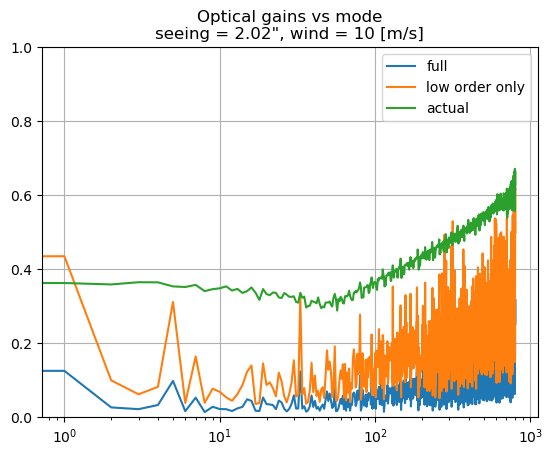

In [15]:
cl = myfits.read_fits(os.path.join(ssao.savecalibpath,'rMod4_r05cm_V10_closed_loop_OG.fits'))
# filtOGs = xp.zeros(OGs.shape[1])
# filtloOGs = xp.zeros(OGs.shape[1])

# for j in range(OGs.shape[1]):
#     filtOGs[j] = xp.sqrt(xp.sum(OGs[:,j]**2*(OGs[:,j]>0)*(OGs[:,j]<1.0))/xp.sum((OGs[:,j]>0)*(OGs[:,j]<1.0)))
#     filtloOGs[j] = xp.sqrt(xp.sum(loOGs[:,j]**2*(loOGs[:,j]>0)*(loOGs[:,j]<1.0))/xp.sum((loOGs[:,j]>0)*(loOGs[:,j]<1.0)))

plt.figure()
plt.plot(xp.asnumpy(OGs),label='full')
plt.plot(xp.asnumpy(loOGs),label='low order only')
plt.plot(xp.asnumpy(cl),label='actual')
plt.legend()
plt.title(f'Optical gains vs mode\nseeing = {0.98*500e-9/r0*180/xp.pi*3600:1.2f}", wind = {Vwind:1.0f} [m/s]')
plt.xscale('log')
plt.ylim([0,1])
plt.grid()

/tmp/ipykernel_144071/3470174482.py:10: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


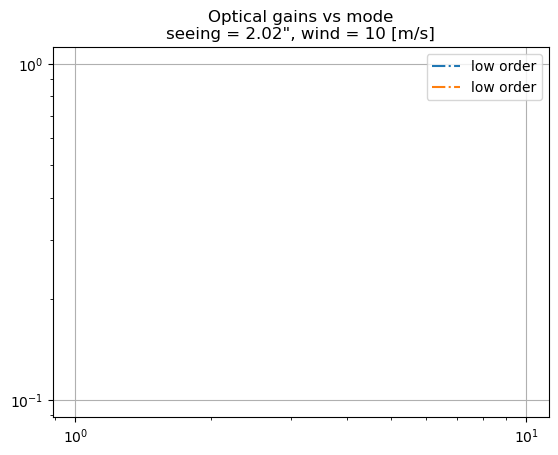

In [16]:
plt.figure()
# plt.plot(xp.asnumpy(xp.min(loOGs,axis=0)),'-.',label='closed loop (min)')

plt.plot(xp.asnumpy(xp.mean(loOGs*(loOGs>0)*(loOGs<1),axis=0)),'-.',label='low order')
plt.plot(xp.asnumpy(xp.mean(loOGs*(loOGs>0)*(loOGs<1),axis=0)),'-.',label='low order')
# plt.plot(xp.asnumpy(xp.max(loOGs,axis=0)),'-.',label='closed loop (max)')
plt.legend()
plt.title(f'Optical gains vs mode\nseeing = {0.98*500e-9/r0*180/xp.pi*3600:1.2f}", wind = {Vwind:1.0f} [m/s]')
plt.grid()
plt.xscale('log')
plt.yscale('log')

In [17]:
ma_res_screens = myfits.read_fits(os.path.join(ssao.savepath,saveprefix+atmo_prefix+'residual_phases.fits'))
offset = 200
N = 40
loop_residual_phases = xp.zeros([N,int(xp.sum(1-ssao.cmask))])
step = (xp.shape(xp.asarray(ma_res_screens.data))[0]-offset)//N
for j in range(N):
    loop_residual_phases[j,:] = xp.asarray(ma_res_screens[j*step+offset].data[~ma_res_screens[j*step+offset].mask])

ssao.sc.load_reconstructor(IM,m2c)
# cl_opt_gains, pl_opt_gains = ssao.calibrate_optical_gains_from_precorrected_screens(
#                                 loop_residual_phases,
#                                 slope_computer=ssao.sc, MM=KL, IM = IM,
#                                 save_prefix = saveprefix+atmo_prefix, ampsInM=amp, return_perfect_ogs=True)

cl_opt_gains = ssao.calibrate_optical_gains_from_precorrected_screens(
                                loop_residual_phases,
                                slope_computer=ssao.sc, MM=KL, IM=IM,
                                save_prefix = saveprefix+atmo_prefix, ampsInM=amp)#, return_perfect_ogs=True)

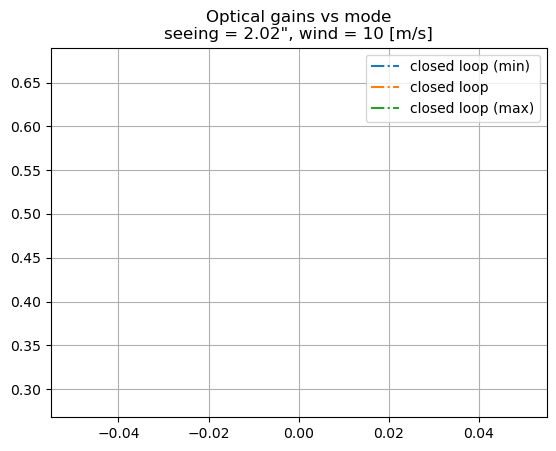

In [18]:
plt.figure()
plt.plot(xp.asnumpy(xp.min(cl_opt_gains,axis=0)),'-.',label='closed loop (min)')
plt.plot(xp.asnumpy(xp.mean(cl_opt_gains,axis=0)),'-.',label='closed loop')
plt.plot(xp.asnumpy(xp.max(cl_opt_gains,axis=0)),'-.',label='closed loop (max)')
# plt.plot(xp.asnumpy(xp.mean(pl_opt_gains,axis=0)),'-.',label='perfect loop')
plt.legend()
plt.title(f'Optical gains vs mode\nseeing = {0.98*500e-9/r0*180/xp.pi*3600:1.2f}", wind = {Vwind:1.0f} [m/s]')
plt.grid()


In [19]:
# cl_A = myfits.read_fits(os.path.join(ssao.savecalibpath,'r010cm_V10_closed_loop_OG.fits'))
# cl_B = myfits.read_fits(os.path.join(ssao.savecalibpath,'deg00_r010cm_V10_closed_loop_OG.fits'))
# cl_C = myfits.read_fits(os.path.join(ssao.savecalibpath,'deg15_r010cm_V10_closed_loop_OG.fits'))
# cl_D = myfits.read_fits(os.path.join(ssao.savecalibpath,'deg90_r010cm_V10_closed_loop_OG.fits'))
# cl_E = myfits.read_fits(os.path.join(ssao.savecalibpath,'deg45_r010cm_V10_closed_loop_OG.fits'))
# pl_A = myfits.read_fits(os.path.join(ssao.savecalibpath,'r010cm_V10_perfect_loop_OG.fits'))
# pl_B = myfits.read_fits(os.path.join(ssao.savecalibpath,'deg00_r010cm_V10_perfect_loop_OG.fits'))
# pl_C = myfits.read_fits(os.path.join(ssao.savecalibpath,'deg15_r010cm_V10_perfect_loop_OG.fits'))
# pl_D = myfits.read_fits(os.path.join(ssao.savecalibpath,'deg90_r010cm_V10_perfect_loop_OG.fits'))
# pl_E = myfits.read_fits(os.path.join(ssao.savecalibpath,'deg45_r010cm_V10_perfect_loop_OG.fits'))

# plt.figure(figsize=(12,4))
# plt.subplot(1,2,1)
# plt.plot(xp.asnumpy(cl_A),'-.')
# # plt.plot(xp.asnumpy(cl_B),'-.')
# plt.plot(xp.asnumpy(cl_C),'-.')
# # plt.plot(xp.asnumpy(cl_D),'-.')
# plt.plot(xp.asnumpy(cl_E),'-.')
# plt.plot(xp.asnumpy(xp.mean(xp.vstack([cl_E,cl_A,cl_C]),axis=0)),'-.')
# plt.grid()
# plt.subplot(1,2,2)
# plt.plot(xp.asnumpy(pl_A),'-.')
# # plt.plot(xp.asnumpy(pl_B),'-.')
# plt.plot(xp.asnumpy(pl_C),'-.')
# # plt.plot(xp.asnumpy(pl_D),'-.')
# plt.plot(xp.asnumpy(xp.mean(xp.vstack([pl_E,pl_A,pl_C]),axis=0)),'-.')
# plt.plot(xp.asnumpy(pl_E),'-.')
# plt.grid()

In [20]:
# plt.figure()
# plt.plot(xp.asnumpy(cl_r10_V10),'-.',label='seeing = 1", wind = 10 m/s')
# plt.plot(xp.asnumpy(cl_r6_V10),'-.',label='seeing = 1.5", wind = 10 m/s')
# plt.plot(xp.asnumpy(cl_r5_V10),'-.',label='seeing = 2", wind = 10 m/s')

# plt.plot(xp.asnumpy(cl_r10_V15),'-.',label='seeing = 1",wind = 15 m/s')
# plt.plot(xp.asnumpy(cl_r10_V17),'-.',label='seeing = 1",wind = 17 m/s')
# plt.plot(xp.asnumpy(cl_r10_V20),'-.',label='seeing = 1",wind = 20 m/s')

# plt.grid()
# plt.ylim([0,1.0])
# plt.legend()

In [21]:
def show_residual_and_ogs_vs_outer_scale(optsys, prefixes:list, start:int=500):
    
    N = len(prefixes)
    phase2modes = xp.linalg.pinv(KL.T)
    plt.figure(figsize=(16,5))
    for prefix in prefixes:
        cl_og = myfits.read_fits(os.path.join(optsys.savecalibpath,prefix+'closed_loop_OG.fits'))
        res_phases,atmo_phases = optsys.load_telemetry_data(['residual_phases','atmo_phases'], save_prefix=prefix)
        def get_phase(vec,id:int):
            return xp.asarray(vec[id].data[~vec[id].mask])
        
        atmo_rms = xp.zeros(xp.shape(phase2modes)[0])
        mode_rms = xp.zeros(xp.shape(phase2modes)[0])
        L = len(res_phase)
        for jj in range(start,L):
            res = get_phase(res_phases,jj)
            modes = phase2modes @ res
            mode_rms += modes**2
            res = get_phase(atmo_phases,jj)
            modes = phase2modes @ res
            atmo_rms += modes**2
        atmo_rms = xp.sqrt(atmo_rms/(L-start))
        mode_rms = xp.sqrt(mode_rms/(L-start))

        plt.subplot(1,2,1)
        # plt.plot(xp.asnumpy(atmo_rms),'-.')
        plt.plot(xp.asnumpy(mode_rms),'--')

        plt.subplot(1,2,2)
        plt.plot(xp.asnumpy(cl_og))

    plt.subplot(1,2,1)
    plt.grid()
    plt.legend((r'$L_0$ = 5m',r'$L_0$ = 25m',r'$L_0$ = 40m',r'$L_0$ = 100m'))
    plt.xscale('log')
    plt.yscale('log')
    plt.subplot(1,2,2)
    plt.grid()
    plt.legend((r'$L_0$ = 5m',r'$L_0$ = 25m',r'$L_0$ = 40m',r'$L_0$ = 100m'))
    plt.xscale('log')
    plt.yscale('log')

In [22]:
def show_ogs_and_mtf_res(optsys, prefixes:list, start:int=500, mod_prefix=''):
    rad_ratios = None
    cl_ogs = None
    modes_rms = None
    meas_modes_rms = None
    N = len(prefixes)
    phase2modes = xp.linalg.pinv(KL.T)
    rms_nms = xp.zeros(N)

    for j,prefix in enumerate(prefixes):
        print(f'\rPrefix {j+1:1.0f}/{N:1.0f}',end='\r',flush=True)
        res_phase,rec_modes = optsys.load_telemetry_data(['residual_phases','reconstructor_modes'], save_prefix=mod_prefix+prefix)
        def get_residual(id:int):
            return xp.asarray(res_phase[id].data[~res_phase[id].mask])

        mtf0 = get_mtf(optsys.pyr, get_residual(0)*0, optsys.cmask, optsys.pupilSizeInM)
        mtf = xp.zeros_like(mtf0)   

        mode_rms = xp.zeros(xp.shape(phase2modes)[0])
        opd_rms = 0.0
        L = len(res_phase)
        for jj in range(start,L):
            res = get_residual(jj)
            modes = phase2modes @ res
            mode_rms += modes**2
            opd_rms += xp.sqrt(xp.sum(res**2)/len(res))
            mtf += get_mtf(optsys.pyr, res, optsys.cmask, optsys.pupilSizeInM)/(L-start)
        opd_rms /= (L-start)
        mode_rms = xp.sqrt(mode_rms/(L-start))
        # print(f'{opd_rms*1e+9:1.1f}nm, {prefix}')
        rms_nms[j] = opd_rms*1e+9

        ratio = mtf/mtf0
        Npix = max(xp.shape(ratio))
        rad_ratio, distance = computeRadialProfile(xp.asnumpy(ratio), centerInPxX=Npix//2, centerInPxY=Npix//2)
        cl_og = myfits.read_fits(os.path.join(optsys.savecalibpath,mod_prefix+prefix+'closed_loop_OG.fits'))

        if j == 0:
            rad_ratios = xp.zeros([len(prefixes),len(rad_ratio)])
            cl_ogs = xp.zeros([len(prefixes),len(cl_og)])
            modes_rms = xp.zeros([len(prefixes),len(mode_rms)])
            meas_modes_rms = xp.zeros([len(prefixes),xp.shape(rec_modes)[1]])
        
        rad_ratios[j] = xp.asarray(rad_ratio)
        cl_ogs[j] = cl_og
        modes_rms[j] = mode_rms
        meas_modes_rms[j] = xp.sqrt(xp.sum(rec_modes[start:,:]**2,axis=0)/(L-start))

    Nmax = 140
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    for j in range(N):
        plt.plot(xp.asnumpy(distance[:Nmax]/Nmax),xp.asnumpy(rad_ratios[j,:Nmax]),'-.',label=f'res = {rms_nms[j]:1.1f}nm')
    plt.legend()
    plt.grid()
    plt.ylim([0,1])
    plt.xlabel(r'$\dfrac{D}{\lambda z}$')
    plt.title(r'Radial profile of $\dfrac{MTF_{avg}}{MTF_{DL}}$')
    plt.subplot(1,2,2)
    for j in range(N):
        plt.plot(xp.asnumpy(cl_ogs[j]),'-.',label=f'res = {rms_nms[j]:1.1f}nm')
    plt.legend()
    plt.xlabel('KL mode #')
    plt.xscale('log')
    plt.grid()
    plt.ylim([0,1])
    plt.title('Optical gains')

    Nmodes = xp.shape(rec_modes)[1]
    plt.figure(figsize=(16,6))
    plt.subplot(1,2,1)
    for j in range(N):
        plt.plot(xp.asnumpy(modes_rms[j,:Nmodes])*1e+9,'-.',label=f'res = {rms_nms[j]:1.1f}nm')
    plt.legend()
    plt.grid()
    plt.ylim([0.2,50])
    plt.yscale('log')
    plt.ylabel('RMS [nm]')
    plt.xlabel('KL mode #')
    plt.xscale('log')
    plt.title('True residual')
    plt.subplot(1,2,2)
    for j in range(N):
        plt.plot(xp.asnumpy(meas_modes_rms[j,:Nmodes])*1e+9,'-.',label=f'res = {rms_nms[j]:1.1f}nm')
    plt.legend()
    plt.grid()
    plt.ylim([0.2,50])
    plt.yscale('log')
    plt.ylabel('RMS [nm]')
    plt.xlabel('KL mode #')
    plt.xscale('log')
    plt.title('Measured residual')

    return rms_nms, cl_ogs, rad_ratios, modes_rms, meas_modes_rms

In [23]:
# rms_nms, cl_ogs, rad_ratios, mode_rms, meas_mode_rms = show_ogs_and_mtf_res(ssao2m, prefixes=['r015cm_V10_','r010cm_V10_','r06cm_V10_','r010cm_V20_','r010cm_V17_','r010cm_V15_','r010cm_V8_']) #'r04cm_V10_','r03cm_V10_',
# rms_nms, cl_ogs, rad_ratios, mode_rms, meas_mode_rms = show_ogs_and_mtf_res(ssao, prefixes=['r015cm_V10_','r010cm_V10_','r06cm_V10_','r05cm_V10_'],mod_prefix='rMod3_') #,'r010cm_V17_','r010cm_V15_','r010cm_V8_''r04cm_V10_','r03cm_V10_',
# rms_nms, cl_ogs, rad_ratios, mode_rms, meas_mode_rms = show_ogs_and_mtf_res(ssao, prefixes=['r015cm_V10_','r015cm_V15_','r010cm_V10_','r015cm_V20_'],mod_prefix='rMod0_')#'r010cm_V15_',
# rms_nms, cl_ogs, rad_ratios, mode_rms, meas_mode_rms = show_ogs_and_mtf_res(ssao, prefixes=['r05cm_V10_','r06cm_V10_','r010cm_V10_','r015cm_V10_'],mod_prefix='rMod2_')
rms_nms, cl_ogs, rad_ratios, mode_rms, meas_mode_rms = show_ogs_and_mtf_res(ssao, prefixes=['rMod0_r010cm_V10_','rMod2_r010cm_V10_','rMod3_r010cm_V10_','rMod4_r010cm_V10_'],mod_prefix='')

File /home/matte/git/ekarus/ekarus/simulations/results/calib_amplitude_8m/rMod0_r010cm_V10_residual_phases.fits not found, trying /home/matte/git/ekarus/ekarus/simulations/results/calib_amplitude_8m/residual_phases.fits instead


FileNotFoundError: [Errno 2] No such file or directory: '/home/matte/git/ekarus/ekarus/simulations/results/calib_amplitude_8m/residual_phases.fits'

Text(0.5, 1.0, 'Measured residual x OGs')

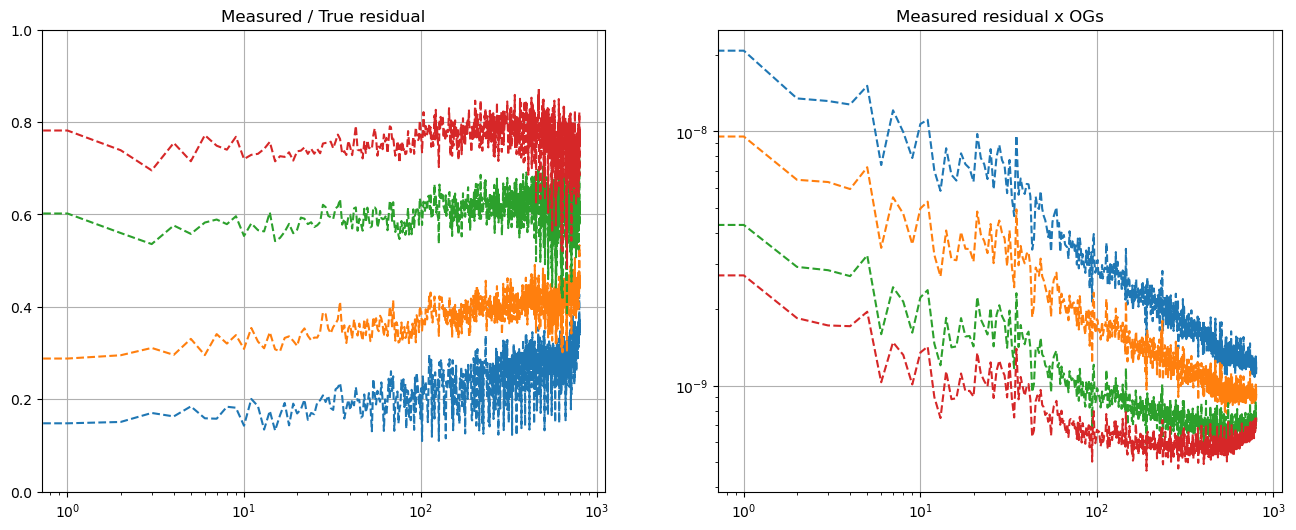

In [ ]:
Ncut = ssao.sc.nModes

plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(xp.asnumpy(meas_mode_rms/mode_rms[:,:Ncut]).T,'--')
plt.grid()
plt.xscale('log')
plt.ylim([0,1])
plt.title('Measured / True residual')
plt.subplot(1,2,2)
plt.plot(xp.asnumpy(1/cl_ogs*meas_mode_rms).T,'--')
# plt.plot(xp.asnumpy(abs(1/cl_ogs*meas_mode_rms-mode_rms[:,:Ncut])).T,'--')
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.title('Measured residual x OGs')

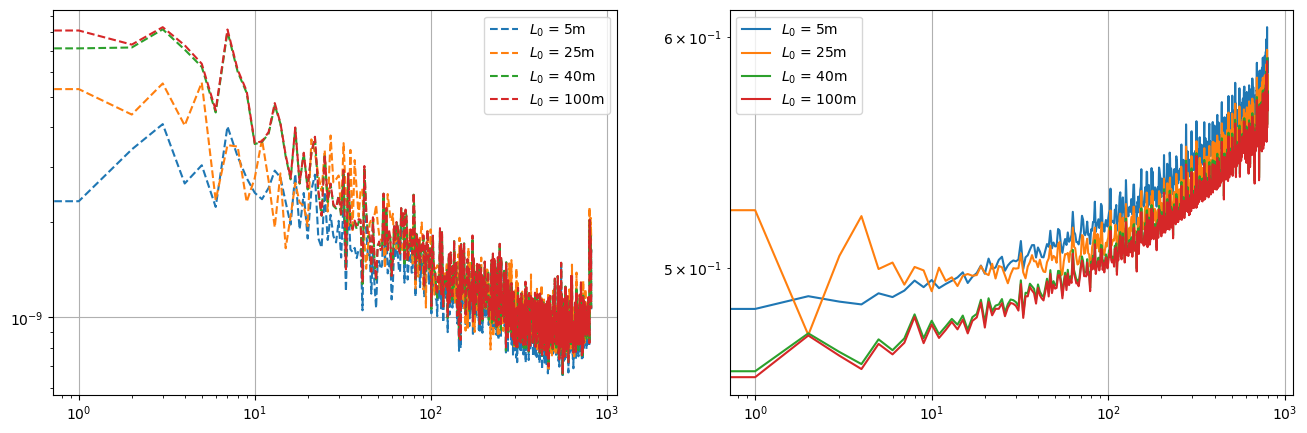

In [ ]:
show_residual_and_ogs_vs_outer_scale(ssao,prefixes=['outerScale_5m_rMod0_r010cm_V10_','rMod0_r010cm_V10_','outerScale_40m_rMod0_r010cm_V10_','outerScale_100m_rMod0_r010cm_V10_'])